## Import dependencies

In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import scipy as sp
from tqdm import tqdm
import glob
import xarray as xr
from zipfile import ZipFile

from fair import *
from fair.scripts.data_retrieval import *

%matplotlib inline

# Constraining a large ensemble

In this notebook, we use the information provided by the global warming index to constrain the "FULL" ensemble results produced in `FULL-compute`.

We constrain the distribution on the basis of anthropogenic contributions to the level and rate of warming over 2010-2019.

In [2]:
FULL_stats = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/FULL_ALL.h5')
anthro_forc_components = ['aci', 'ari', 'bc_on_snow', 'carbon_dioxide', 'contrails', 'methane','nitrous_oxide', 'other_wmghgs', 'ozone', 'strat_h2o', 'LUC']

FULL_stats['anthro_2019'] = FULL_stats[[x+'_2019' for x in anthro_forc_components]].sum(axis=1)
FULL_stats['aer_2019'] = FULL_stats[['aci_2019', 'ari_2019']].sum(axis=1)

### Select a posterior sample

Now use the likelihoods calculated in `global-warming-index` to select a distribution of ensemble members that are consistent with the AWI informtion.

In [3]:
## choose the datasets to use here:
datasets_to_use = ['HadCRUT5','HadCRUT4','NOAA','GISTEMP','CW','BERKELEY']

FULL_probabilities = pd.concat([pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/FULL_selection_probability-'+x+'.h5') for x in datasets_to_use],axis=1,keys=datasets_to_use)
## create boolean mask of selected ensemble members, averaging the likelihood over the chosen observational datasets
FULL_ensemble_selection = FULL_probabilities.mean(axis=1)>np.random.random(FULL_probabilities.shape[0])

### climate sensitivity & present-day RF statistics

In [4]:
## output to ltx table
choose_stats = ['ECS', 'TCR', 'aci_2019', 'ari_2019', 'aer_2019', 'bc_on_snow_2019', 'carbon_dioxide_2019', 'contrails_2019', 'methane_2019','nitrous_oxide_2019', 'other_wmghgs_2019', 'ozone_2019', 'strat_h2o_2019', 'LUC_2019', 'anthro_2019']
map_forc_names = dict(zip(['Total','aci_2019','aer_2019','anthro_2019','ari_2019','bc_on_snow_2019','carbon_dioxide_2019','contrails_2019','methane_2019','nitrous_oxide_2019','other_wmghgs_2019','ozone_2019','strat_h2o_2019','LUC_2019'],
                          ['total','aerosol-cloud interaction','total aerosol','total anthropogenic','aerosol-radation interaction','black carbon on snow','CO$_2$','contrails','CH$_4$','N$_2$O','other WMGHGs','ozone','stratospheric H$_2$O from CH$_4$','albedo from land use change']))

constraint_table = pd.concat([FULL_stats[choose_stats].describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2),
                               FULL_stats[choose_stats].loc[FULL_ensemble_selection].describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2)],
                              axis=1,keys=['FULL','CONSTRAINED']).loc[['ECS','TCR','carbon_dioxide_2019','methane_2019','nitrous_oxide_2019','other_wmghgs_2019','ozone_2019','strat_h2o_2019','ari_2019','aci_2019','aer_2019','bc_on_snow_2019','contrails_2019','LUC_2019','anthro_2019']].rename(map_forc_names)

constraint_table = pd.concat([constraint_table.iloc[:2],constraint_table.iloc[2:]],keys=['climate sensitivities / K','2019 ERF components / W m$^{-2}$'])
constraint_table.columns.names=['ensemble','percentile']
constraint_table=constraint_table.rename(dict(zip(constraint_table.columns.levels[1],[x.replace('%','\%') for x in constraint_table.columns.levels[1]])),axis=1,level=1)
constraint_table#.to_latex('../../docs/manuscript/tables/Tab7',escape=False,bold_rows=True,multirow=True)

ensemble                                                           FULL  \
percentile                                                          5\%   
climate sensitivities / K        ECS                               1.80   
                                 TCR                               1.14   
2019 ERF components / W m$^{-2}$ CO$_2$                            1.61   
                                 CH$_4$                            0.45   
                                 N$_2$O                            0.16   
                                 other WMGHGs                      0.29   
                                 ozone                             0.24   
                                 stratospheric H$_2$O from CH$_4$  0.01   
                                 aerosol-radation interaction     -0.60   
                                 aerosol-cloud interaction        -2.28   
                                 total aerosol                    -2.63   
                                 black carbon on snow              0.04   
                                 contrails                         0.01   
                                 albedo from land use change      -0.35   
                                 total anthropogenic               1.01   

ensemble                                                                  \
percentile                                                        16.6\%   
climate sensitivities / K        ECS                                2.45   
                                 TCR                                1.48   
2019 ERF components / W m$^{-2}$ CO$_2$                             1.81   
                                 CH$_4$                             0.52   
                                 N$_2$O                             0.17   
                                 other WMGHGs                       0.32   
                                 ozone                              0.33   
                                 stratospheric H$_2$O from CH$_4$   0.03   
                                 aerosol-radation interaction      -0.47   
                                 aerosol-cloud interaction         -1.47   
                                 total aerosol                     -1.81   
                                 black carbon on snow               0.06   
                                 contrails                          0.03   
                                 albedo from land use change       -0.29   
                                 total anthropogenic                1.85   

ensemble                                                                 \
percentile                                                         50\%   
climate sensitivities / K        ECS                               3.69   
                                 TCR                               2.03   
2019 ERF components / W m$^{-2}$ CO$_2$                            2.12   
                                 CH$_4$                            0.62   
                                 N$_2$O                            0.20   
                                 other WMGHGs                      0.36   
                                 ozone                             0.47   
                                 stratospheric H$_2$O from CH$_4$  0.05   
                                 aerosol-radation interaction     -0.30   
                                 aerosol-cloud interaction        -0.69   
                                 total aerosol                    -1.02   
                                 black carbon on snow              0.09   
                                 contrails                         0.06   
                                 albedo from land use change      -0.20   
                                 total anthropogenic               2.73   

ensemble                                                                  \
percentile                                                        83.3\%   
cli

### climate sensitivity comparison

We compare our posterior estimates of climate sensitivity to recent estimates from the literature.

References:

Nijsse, F. J. M. M., Cox, P. M., & Williamson, M. S. (2020). Emergent constraints on transient climate response (TCR) and equilibrium climate sensitivity (ECS) from historical warming in CMIP5 and CMIP6 models. Earth System Dynamics, 11(3), 737–750. https://doi.org/10.5194/esd-11-737-2020

Tokarska, K. B., Stolpe, M. B., Sippel, S., Fischer, E. M., Smith, C. J., Lehner, F., & Knutti, R. (2020). Past warming trend constrains future warming in CMIP6 models. Science Advances, 6(12), 9549–9567. https://doi.org/10.1126/sciadv.aaz9549

Sherwood, S., Webb, M. J., Annan, J. D., Armour, K. C., Forster, P. M., Hargreaves, J. C., … Zelinka, M. D. (2020). An assessment of Earth’s climate sensitivity using multiple lines of evidence. Reviews of Geophysics. https://doi.org/10.1029/2019rg000678

Jiménez-de-la-Cuesta, D., & Mauritsen, T. (2019). Emergent constraints on Earth’s transient and equilibrium response to doubled CO2 from post-1970s global warming. Nature Geoscience. https://doi.org/10.1038/s41561-019-0463-y

In [5]:
climresp_CMIP6 = pd.read_csv('../../aux/parameter-sets/CMIP6_climresp.csv',index_col=0,header=[0,1]).stack()
f_params_CMIP6 = pd.read_csv('../../aux/parameter-sets/CMIP6_f_params.csv',index_col=0)
F2x_CMIP6 = f_params_CMIP6.loc['f1']*np.log(2) + f_params_CMIP6.loc['f3'] * (np.sqrt(2*278)-np.sqrt(278))
ECS_CMIP6 = F2x_CMIP6 * climresp_CMIP6.loc['q'].sum()
TCR_CMIP6 = F2x_CMIP6 * ( climresp_CMIP6.loc['q'] * ( 1 - climresp_CMIP6.loc['d']/69.66 * ( 1 - np.exp(-69.66/climresp_CMIP6.loc['d'] ) ) ) ).sum()
RWF_CMIP6 = TCR_CMIP6 / ECS_CMIP6

## we also calculate the ECS usign the Gregory method over the first 150 years of the abrupt-4xCO2 experiment
abrupt_4xCO2_data = xr.open_dataset('../../aux/input-data/CMIP6/CMIP6_tuning_data.nc').sel(scenario='abrupt-4xCO2',time=slice('1850','1999')).mean('member_id').dropna('climate_model')

ECS_CMIP6_greg = pd.Series(index=ECS_CMIP6.index,dtype=float)
for model in abrupt_4xCO2_data.climate_model.values:
    ECS_CMIP6_greg.loc[model] = sp.stats.linregress(abrupt_4xCO2_data.rndt.sel(climate_model=model).values,abrupt_4xCO2_data.tas.sel(climate_model=model).values).intercept/2
    
clim_sens_comp = pd.DataFrame(columns=pd.MultiIndex.from_product([['ECS','TCR'],[5,17,50,83,95]]))

clim_sens_comp.loc['FULL','ECS'] = FULL_stats.loc[:,'ECS'].quantile([.05,.166,.5,.833,.95]).values
clim_sens_comp.loc['FULL','TCR'] = FULL_stats.loc[:,'TCR'].quantile([.05,.166,.5,.833,.95]).values

clim_sens_comp.loc['CONSTRAINED','ECS'] = FULL_stats.loc[FULL_ensemble_selection,'ECS'].quantile([.05,.166,.5,.833,.95]).values
clim_sens_comp.loc['CONSTRAINED','TCR'] = FULL_stats.loc[FULL_ensemble_selection,'TCR'].quantile([.05,.166,.5,.833,.95]).values

clim_sens_comp.loc['B20','ECS'] = [np.nan]*5
clim_sens_comp.loc['B20','TCR'] = [1.38,np.nan,1.83,np.nan,2.43]

clim_sens_comp.loc['C19','ECS'] = [1.72,np.nan,2.83,np.nan,4.12]
clim_sens_comp.loc['C19','TCR'] = [1.16,np.nan,1.67,np.nan,2.16]

clim_sens_comp.loc['N20','ECS'] = [1.52,1.9,2.6,3.4,4.03]
clim_sens_comp.loc['N20','TCR'] = [1.0,1.29,1.68,2.05,2.3]

clim_sens_comp.loc['R21','ECS'] = [2.3,np.nan,np.nan,np.nan,4.6]
clim_sens_comp.loc['R21','TCR'] = [1.33,np.nan,1.84,np.nan,2.35]

clim_sens_comp.loc['S20','ECS'] = [2.3,2.6,3.1,3.9,4.7]
clim_sens_comp.loc['S20','TCR'] = [np.nan,1.5,1.8,2.2,np.nan]

clim_sens_comp.loc['S20-robust','ECS'] = [2.0,2.3,np.nan,4.1,5.7]
clim_sens_comp.loc['S20-robust','TCR'] = [np.nan]*5

clim_sens_comp.loc['T20','ECS'] = [np.nan]*5
clim_sens_comp.loc['T20','TCR'] = [np.nan,1.2,1.6,1.99,np.nan]

## response_df

clim_sens_comp.loc['CMIP6','ECS'] = ECS_CMIP6.quantile([0.05,0.166,0.5,0.833,0.95]).values
clim_sens_comp.loc['CMIP6*','ECS'] = ECS_CMIP6_greg.quantile([0.05,0.166,0.5,0.833,0.95]).values
clim_sens_comp.loc['CMIP6','TCR'] = TCR_CMIP6.quantile([0.05,0.166,0.5,0.833,0.95]).values    

set some matplotlib rcParams

In [6]:
matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11

matplotlib.rcParams['axes.formatter.limits']=-3,3

matplotlib.rcParams['legend.frameon']=False

plt.rcParams['pdf.fonttype'] = 42

/nfs/a65/pmcjs/miniconda3/envs/leach2021/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  if __name__ == '__main__':
/nfs/a65/pmcjs/miniconda3/envs/leach2021/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  if __name__ == '__main__':
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


''

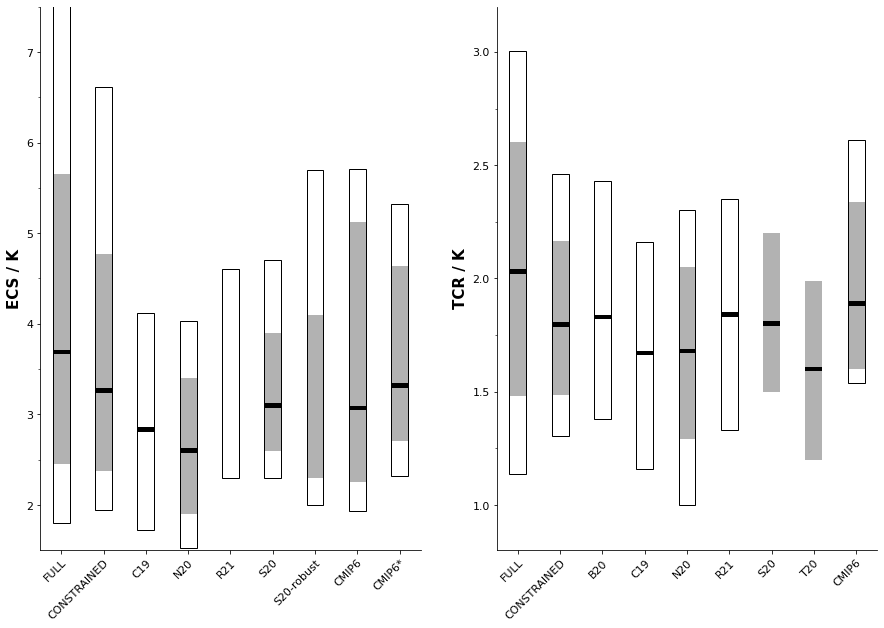

In [7]:
fig,ax = plt.subplots(1,2,figsize=(15,10))

# scale the median bar height by the RWF for consistency
height_scaling = dict(ECS=1,TCR=0.4)

for ii,sens in enumerate(['ECS','TCR']):
    for i,source in enumerate(clim_sens_comp[sens].dropna(how='all').index):
    
        ax[ii].bar(i,clim_sens_comp.loc[source,sens][95]-clim_sens_comp.loc[source,sens][5],0.4,clim_sens_comp.loc[source,sens][5],color='',ec='k')
        ax[ii].bar(i,clim_sens_comp.loc[source,sens][83]-clim_sens_comp.loc[source,sens][17],0.4,clim_sens_comp.loc[source,sens][17],color='k',alpha=0.3)

        ax[ii].bar(i,0.05*height_scaling[sens],0.4,clim_sens_comp.loc[source,sens][50]-0.025*height_scaling[sens],color='k',)
        
    ax[ii].set_xticks(np.arange(clim_sens_comp[sens].dropna(how='all').index.size))
    ax[ii].set_xticklabels(clim_sens_comp[sens].dropna(how='all').index,rotation=45,rotation_mode='anchor',ha='right')
    
    ax[ii].set_xlim(-0.5,clim_sens_comp[sens].dropna(how='all').index.size-0.5)
    
[a.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2)) for a in ax]

[a.spines[pos].set_visible(False) for a in ax for pos in ['right','top']]

ax[0].set_ylim(1.5,7.5)
ax[1].set_ylim(0.8,3.2)

ax[0].set_ylabel('ECS / K',fontweight='bold',fontsize=15)
ax[1].set_ylabel('TCR / K',fontweight='bold',fontsize=15)

[fig.savefig('../../docs/manuscript/figures/Fig6.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
''

## Constrained warming projections

Here we examine warming projections implied by the constrained ensemble under a range of scenarios.

In [8]:
ssp_files = glob.glob('../../aux/parameter-sets/perturbed-parameters/ssp*.h5')
ssp_stats = pd.concat([pd.read_hdf(x) for x in ssp_files],axis=1,keys=[x.split('/')[-1].split('.')[0] for x in ssp_files]).swaplevel(0,1,axis=1).sort_index(axis=1)

In [9]:
projection_table = pd.concat([
    pd.concat([(ssp_stats.T_2081_2100-ssp_stats.T_1995_2014).describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2),
               (ssp_stats.T_2081_2100-ssp_stats.T_1995_2014).loc[FULL_ensemble_selection].describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2)],
              axis=1,
              keys=['FULL','CONSTRAINED']),
    pd.concat([(ssp_stats.T_peak-ssp_stats.T_1995_2014).describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2),
               (ssp_stats.T_peak-ssp_stats.T_1995_2014).loc[FULL_ensemble_selection].describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2)],
              axis=1,
              keys=['FULL','CONSTRAINED']).loc[['ssp119','ssp126','ssp534-over']],
    pd.concat([(ssp_stats[[x+'_2100' for x in anthro_forc_components]].groupby(axis=1,level=1).sum()).describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2),
               (ssp_stats[[x+'_2100' for x in anthro_forc_components]].groupby(axis=1,level=1).sum()).loc[FULL_ensemble_selection].describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2)],
              axis=1,
              keys=['FULL','CONSTRAINED'])
        ],
    axis=0,
    keys=['2081-2100 warming relative to 1995-2014 / K','peak warming relative to 1995-2014 / K','2100 anthropogenic ERF / W m$^{-2}$']
).CONSTRAINED

projection_table = projection_table.rename(dict(zip(projection_table.columns,[x.replace('%','\%') for x in projection_table.columns])),axis=1)
projection_table.columns.name='percentile'
projection_table#.to_latex('../../docs/manuscript/tables/Tab10',escape=False,bold_rows=True,multirow=True)

percentile                                                              5\%  \
2081-2100 warming relative to 1995-2014 / K ssp119                     0.16   
                                            ssp126                     0.46   
                                            ssp245                     1.19   
                                            ssp370                     2.01   
                                            ssp370-lowNTCF-aerchemmip  2.03   
                                            ssp370-lowNTCF-gidden      1.62   
                                            ssp434                     0.76   
                                            ssp460                     1.48   
                                            ssp534-over                0.73   
                                            ssp585                     2.51   
peak warming relative to 1995-2014 / K      ssp119                     0.44   
                                            ssp126                     0.57   
                                            ssp534-over                1.08   
2100 anthropogenic ERF / W m$^{-2}$         ssp119                     1.86   
                                            ssp126                     2.45   
                                            ssp245                     4.20   
                                            ssp370                     6.37   
                                            ssp370-lowNTCF-aerchemmip  6.69   
                                            ssp370-lowNTCF-gidden      5.65   
                                            ssp434                     2.99   
                                            ssp460                     4.85   
                                            ssp534-over                2.75   
                                            ssp585                     7.79   

percentile                                                             16.6\%  \
2081-2100 warming relative to 1995-2014 / K ssp119                       0.30   
                                            ssp126                       0.63   
                                            ssp245                       1.42   
                                            ssp370                       2.29   
                                            ssp370-lowNTCF-aerchemmip    2.36   
                                            ssp370-lowNTCF-gidden        1.91   
                                            ssp434                       0.93   
                                            ssp460                       1.74   
                                            ssp534-over                  0.94   
                                            ssp585                       2.90   
peak warming relative to 1995-2014 / K      ssp119                       0.55   
                                            ssp126                       0.73   
                                            ssp534-over                  1.30   
2100 anthropogenic ERF / W m$^{-2}$         ssp119                       2.05   
                                            ssp126                       2.69   
                                            ssp245                       4.58   
                                            ssp370                       6.96   
                                            ssp370-lowNTCF-aerchemmip    7.26   
                                            ssp370-lowNTCF-gidden        6.20   
                                            ssp434                       3.28   
                                            ssp460                       5.28   
                                            ssp534-over                  3.04   
                                            ssp585                       8.46   

percentile                                                             50\%  \
2081-2100 warming relative to 1995-2014 / K ssp119                     0.57   


identical table but for projections relative to 1850-1900 + instantaneous 2100 warming

In [10]:
projection_table1 = pd.concat([
    pd.concat([(ssp_stats.T_2081_2100-ssp_stats.T_1850_1900).describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2),
               (ssp_stats.T_2081_2100-ssp_stats.T_1850_1900).loc[FULL_ensemble_selection].describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2)],
              axis=1,
              keys=['FULL','CONSTRAINED']),
    pd.concat([(ssp_stats.T_2100-ssp_stats.T_1850_1900).describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2),
               (ssp_stats.T_2100-ssp_stats.T_1850_1900).loc[FULL_ensemble_selection].describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2)],
              axis=1,
              keys=['FULL','CONSTRAINED']),
    pd.concat([(ssp_stats.T_peak-ssp_stats.T_1850_1900).describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2),
               (ssp_stats.T_peak-ssp_stats.T_1850_1900).loc[FULL_ensemble_selection].describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2)],
              axis=1,
              keys=['FULL','CONSTRAINED']).loc[['ssp119','ssp126','ssp534-over']],
    ],
    axis=0,
    keys=['2081-2100 warming relative to 1850-1900 / K','2100 warming relative to 1850-1900 / K','peak warming relative to 1850-1900 / K']
).CONSTRAINED

projection_table1 = projection_table1.rename(dict(zip(projection_table1.columns,[x.replace('%','\%') for x in projection_table1.columns])),axis=1)
projection_table1.columns.name='percentile'
projection_table1#.to_latex('../../docs/manuscript/tables/TabS6',escape=False,bold_rows=True,multirow=True)

percentile                                                              5\%  \
2081-2100 warming relative to 1850-1900 / K ssp119                     1.00   
                                            ssp126                     1.28   
                                            ssp245                     2.00   
                                            ssp370                     2.79   
                                            ssp370-lowNTCF-aerchemmip  2.83   
                                            ssp370-lowNTCF-gidden      2.43   
                                            ssp434                     1.56   
                                            ssp460                     2.29   
                                            ssp534-over                1.55   
                                            ssp585                     3.31   
2100 warming relative to 1850-1900 / K      ssp119                     0.95   
                                            ssp126                     1.24   
                                            ssp245                     2.03   
                                            ssp370                     3.04   
                                            ssp370-lowNTCF-aerchemmip  3.08   
                                            ssp370-lowNTCF-gidden      2.64   
                                            ssp434                     1.53   
                                            ssp460                     2.35   
                                            ssp534-over                1.45   
                                            ssp585                     3.58   
peak warming relative to 1850-1900 / K      ssp119                     1.25   
                                            ssp126                     1.39   
                                            ssp534-over                1.90   

percentile                                                             16.6\%  \
2081-2100 warming relative to 1850-1900 / K ssp119                       1.16   
                                            ssp126                       1.48   
                                            ssp245                       2.27   
                                            ssp370                       3.13   
                                            ssp370-lowNTCF-aerchemmip    3.21   
                                            ssp370-lowNTCF-gidden        2.76   
                                            ssp434                       1.78   
                                            ssp460                       2.58   
                                            ssp534-over                  1.79   
                                            ssp585                       3.75   
2100 warming relative to 1850-1900 / K      ssp119                       1.11   
                                            ssp126                       1.43   
                                            ssp245                       2.32   
                                            ssp370                       3.42   
                                            ssp370-lowNTCF-aerchemmip    3.49   
                                            ssp370-lowNTCF-gidden        3.00   
                                            ssp434                       1.74   
                                            ssp460                       2.66   
                                            ssp534-over                  1.68   
                                            ssp585                       4.06   
peak warming relative to 1850-1900 / K      ssp119                       1.40   
                                            ssp126                       1.58   
                                            ssp534-over                  2.15   

percentile                                                             50\%  \
2081-2100 warming relative to 1850-1900 / K ssp119                     1.45   


## Relationship between metrics within FULL & CONSTRAINED ensembles

Here we examine correlations between the key metrics using a corner plot.

Chosen metrics:
- ECS
- TCR
- T_2010_2019
- dT_2010_2019
- T_2081_2100
- 2019 ERFaer
- 2019 ERFanthro

First we retrieve some CMIP6 data for comparison.

In [11]:
# we have TCR / ECS, we need aerosol forcing & temperature projections
## import CMIP6 global mean data
def get_CMIP6_data_from_MAG(fname):
    with open(fname) as myFile:
        for num, line in enumerate(myFile, 1):
            if line.lstrip()[:5]=='YEARS':
                startline = num
                break
                
    info_index = tuple(fname.split('/')[-1].split('_')[1:6])
    data_out = pd.read_csv(fname,skiprows=startline-1,delim_whitespace=True,index_col=0).WORLD
    data_out.name = info_index

    return data_out

CMIP6_ssp_files = glob.glob('../../aux/input-data/CMIP6/ssp245*/average-year-mid-year/CMIP6/ScenarioMIP/*/*/*/*/*/*/*/*/*.MAG')
CMIP6_ssp_data = []

for fname in tqdm(CMIP6_ssp_files):
    CMIP6_ssp_data += [get_CMIP6_data_from_MAG(fname)]
    
CMIP6_ssp_data = pd.concat(CMIP6_ssp_data,axis=1).droplevel([0,1,3],axis=1)

CMIP6_hist_files = glob.glob('../../aux/input-data/CMIP6/historical_tas/average-year-mid-year/CMIP6/CMIP/*/*/*/*/*/*/*/*/*.MAG')
CMIP6_hist_data = []

for fname in tqdm(CMIP6_hist_files):
    CMIP6_hist_data += [get_CMIP6_data_from_MAG(fname)]
    
CMIP6_hist_data = pd.concat(CMIP6_hist_data,axis=1).droplevel([0,1,3],axis=1)

# join historical & ssp245 together
for mod_mem in CMIP6_ssp_data.columns:
    if np.isnan(CMIP6_ssp_data.loc[2000,mod_mem]):
        if mod_mem in CMIP6_hist_data.columns:
            CMIP6_ssp_data.loc[1850:2014,mod_mem] = CMIP6_hist_data.loc[1850:2014,mod_mem]
            
CMIP6_T_data = CMIP6_ssp_data.loc[:,~CMIP6_ssp_data.loc[1850].isna()]

# Use fits to RFMIP as variability-free CMIP6 aerosol forcing in 2019
## get the RCMIP emms for the species we use to parameterise ERFaer
aer_emms = RCMIP_to_FaIR_input_emms('ssp245').loc[:2100,['so2','bc','oc']].interpolate()
## relative to 1850
aer_emms -= aer_emms.loc[1750]

ERFaci_coefs = pd.read_csv('../../aux/parameter-sets/CMIP6_ERFaci.csv',index_col=0)
ERFari_coefs = pd.read_csv('../../aux/parameter-sets/CMIP6_ERFari.csv',index_col=0)
CMIP6_ERFaer = pd.DataFrame(columns=ERFari_coefs.index,index=aer_emms.index)

for model in CMIP6_ERFaer.columns:
    FaIRv2_erfari = (aer_emms * ERFari_coefs.loc[model,:]).sum(axis=1)
    FaIRv2_erfaci = ERFaci_coefs.loc[model,'beta'] * np.log(1 + aer_emms['so2'] / ERFaci_coefs.loc[model,'s'] ) + ERFaci_coefs.loc[model,'alpha']*(aer_emms['bc']+aer_emms['oc'])
    CMIP6_ERFaer.loc[:,model] = FaIRv2_erfari+FaIRv2_erfaci
    

## combine CMIP6 data into one dataframe
CMIP6_T_2010_2019 = (CMIP6_T_data.loc[2010:2019].mean()-CMIP6_T_data.loc[1850:1900].mean()).groupby(level=0).mean()
CMIP6_T_2081_2100 = (CMIP6_T_data.loc[2081:2100].mean()-CMIP6_T_data.loc[1850:1900].mean()).groupby(level=0).mean()
CMIP6_dT_2010_2019 = CMIP6_T_data.loc[2000:2029].groupby(axis=1,level=0).mean().apply(lambda x: sp.stats.linregress(np.arange(30),x).slope)
CMIP6_plot_data = pd.concat([ECS_CMIP6,TCR_CMIP6,CMIP6_T_2010_2019,CMIP6_dT_2010_2019,CMIP6_T_2081_2100,CMIP6_ERFaer.loc[2019].rename({'E3SM':'E3SM-1-0'})],
                             axis=1,
                             keys=['ECS','TCR','T_2010_2019','dT_2010_2019','T_2081_2100','aer_2019'])

100%|██████████| 527/527 [00:20<00:00, 25.94it/s]


reshape the data into a nice long-form dataframe for plotting

In [12]:
corner_plot_variables = ['ECS','TCR','T_2010_2019','dT_2010_2019','T_2081_2100','aer_2019','anthro_2019']
corner_plot_data = FULL_stats.loc[:,corner_plot_variables]

# remove PI-baseline
corner_plot_data['T_2010_2019'] -= FULL_stats['T_1850_1900']
corner_plot_data['T_2081_2100'] -= FULL_stats['T_1850_1900']

corner_plot_data = pd.concat([corner_plot_data,corner_plot_data.loc[FULL_ensemble_selection]],keys=['FULL','CONSTRAINED']).reset_index().rename({'level_0':'ensemble'},axis=1)

''

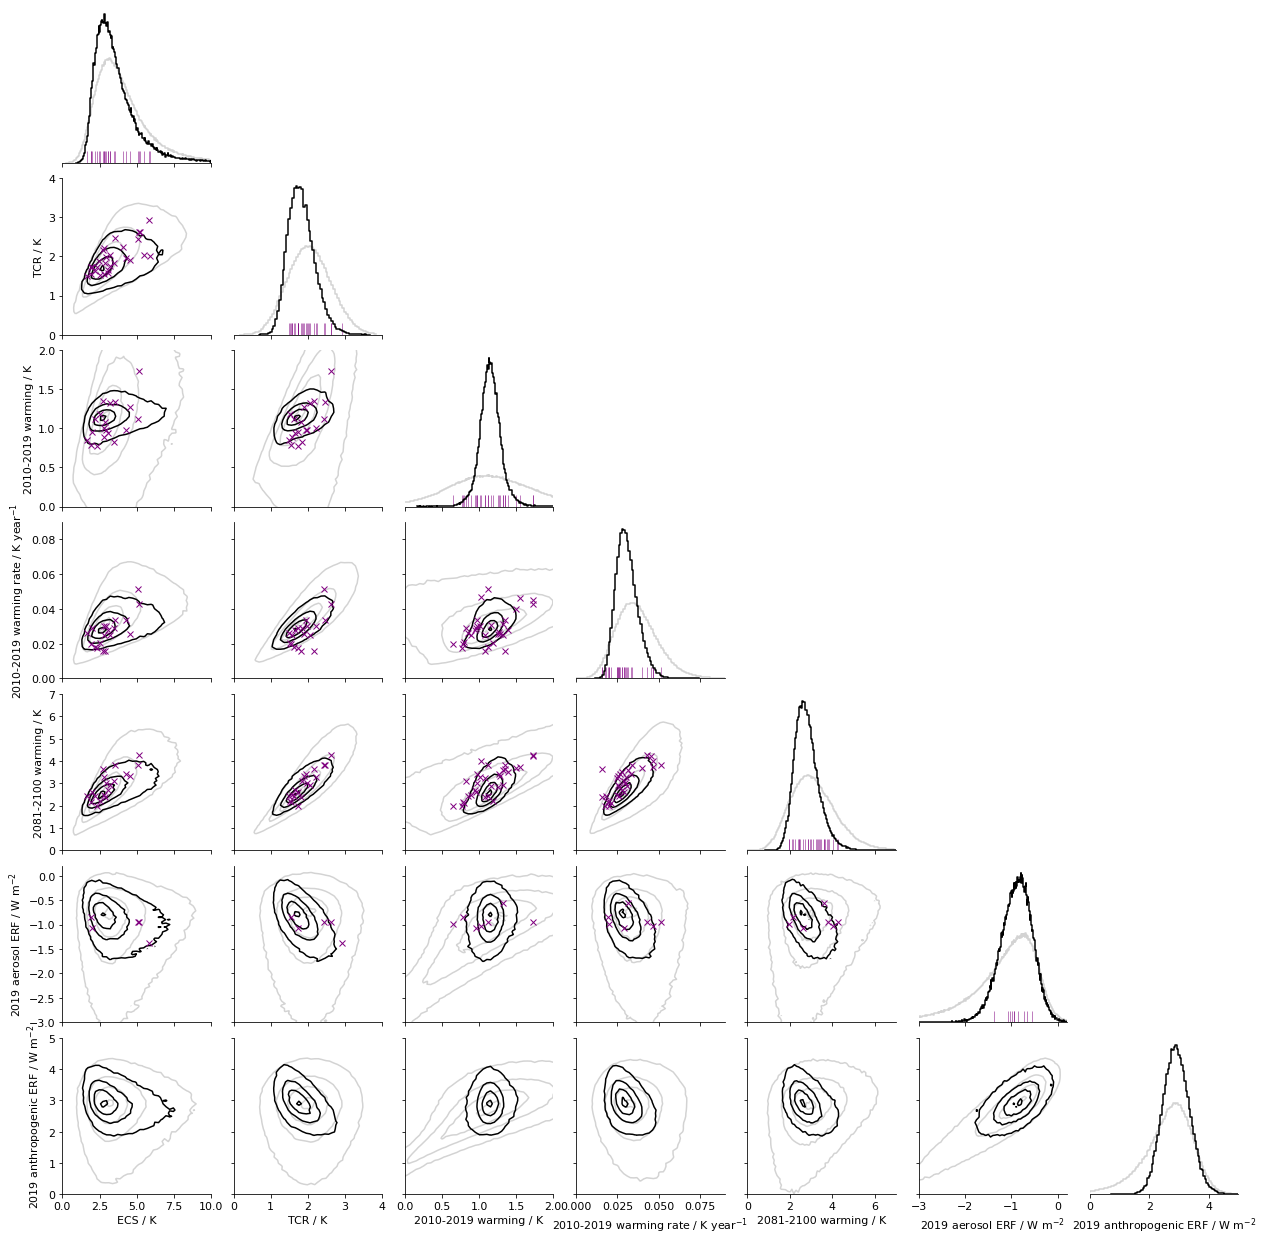

In [13]:
## create a correlation matrix (corner) plot:
resolution_diag = dict(zip(corner_plot_variables,
                           [0.05,0.05,0.01,0.001,0.05,0.01,0.05]))

resolution_lower = dict(zip(corner_plot_variables,
                           [0.25,0.1,0.05,0.002,0.1,0.05,0.1]))

map_var_names = dict(zip(corner_plot_variables,
                         ['ECS / K','TCR / K','2010-2019 warming / K','2010-2019 warming rate / K year$^{-1}$','2081-2100 warming / K','2019 aerosol ERF / W m$^{-2}$','2019 anthropogenic ERF / W m$^{-2}$']))

def diagplot(x,**kwargs):
    sn.histplot(x,
                **kwargs,
                stat='density',
                element='step',
                fill=False,
                binwidth=resolution_diag[x.name])
    
def lowerplot(x,y,**kwargs):
    x_bins = np.arange(np.percentile(x,0.01),np.percentile(x,99.9),resolution_lower[x.name])
    y_bins = np.arange(np.percentile(y,0.01),np.percentile(y,99.9),resolution_lower[y.name])
    binned_statistic = sp.stats.binned_statistic_2d(x,y,None,'count',bins=[x_bins,y_bins])
    plt.contour((binned_statistic.x_edge[:-1]+binned_statistic.x_edge[1:])/2,
                (binned_statistic.y_edge[:-1]+binned_statistic.y_edge[1:])/2,
                binned_statistic.statistic.T/binned_statistic.statistic.max(),
                levels=[0.05,0.33,0.66,0.95],
                colors=[kwargs['color']]
               )

g = sn.PairGrid(corner_plot_data,diag_sharey=False,corner=True,hue='ensemble',palette=['lightgrey','k'],dropna=True)
g.map_lower(lowerplot)
g.map_diag(diagplot)

axes_lims = [[0,10],[0,4],[0,2],[0,0.09],[0,7],[-3,0.2],[0,5]]
for i,y in enumerate(corner_plot_variables):
    for j,x in enumerate(corner_plot_variables):
        
        if j<=i:
            g.axes[i,j].set_xlim(axes_lims[j])
        if j<i:
            g.axes[i,j].set_ylim(axes_lims[i])
            
            # plot some CMIP6 data
            if x in CMIP6_plot_data.columns and y in CMIP6_plot_data.columns:
                g.axes[i,j].plot(*CMIP6_plot_data.loc[:,[x,y]].dropna().values.T,marker='x',color='purple',lw=0)
                
        if j==i:
            if x in CMIP6_plot_data.columns:
                sn.rugplot(CMIP6_plot_data[x].dropna(),ax=g.axes[i,j],color='purple',lw=0.5,height=0.075)
                
[g.axes[-1,i].set_xlabel(map_var_names[x]) for i,x in enumerate(corner_plot_variables)]
[g.axes[i+1,0].set_ylabel(map_var_names[x]) for i,x in enumerate(corner_plot_variables[1:])]

[g.fig.savefig('../../docs/manuscript/figures/Fig7.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
''

## Supplement I - sensitivity of results to different observational series

Here we test the sensitivity of our results to changes in the observational dataset used to compute the global warming index.

References:

Morice, C. P., Kennedy, J. J., Rayner, N. A., Winn, J. P., Hogan, E., Killick, R. E., … Simpson, I. R. (2020). An updated assessment of near‐surface temperature change from 1850: the HadCRUT5 dataset. Journal of Geophysical Research: Atmospheres. https://doi.org/10.1029/2019JD032361

Morice, C. P., Kennedy, J. J., Rayner, N. A., Jones, P. D., P., M. C., J., K. J., … D., J. P. (2011). Quantifying uncertainties in global and regional temperature change using an ensemble of observational estimates: The HadCRUT4 data set. Journal of Geophysical Research: Atmospheres, 117(D8). https://doi.org/10.1029/2011JD017187

Cowtan, K., & Way, R. G. (2014). Coverage bias in the HadCRUT4 temperature series and its impact on recent temperature trends. Quarterly Journal of the Royal Meteorological Society, 140(683), 1935–1944. https://doi.org/10.1002/qj.2297

Lenssen, N. J. L., Schmidt, G. A., Hansen, J. E., Menne, M. J., Persin, A., Ruedy, R., & Zyss, D. (2019). Improvements in the uncertainty model in the Goddard Institute for Space Studies Surface Temperature (GISTEMP) analysis. Journal of Geophysical Research: Atmospheres, 2018JD029522. https://doi.org/10.1029/2018JD029522

Vose, R. S., Arndt, D., Banzon, V. F., Easterling, D. R., Gleason, B., Huang, B., … Wuertz, D. B. (2012). NOAA’s Merged Land–Ocean Surface Temperature Analysis. Bulletin of the American Meteorological Society, 93(11), 1677–1685. https://doi.org/10.1175/BAMS-D-11-00241.1

Rohde, R. A., & Hausfather, Z. (2020). The Berkeley Earth Land/Ocean Temperature Record. Earth System Science Data, 12(4), 3469–3479. https://doi.org/10.5194/essd-12-3469-2020

In [14]:
metrics_to_test = pd.concat([FULL_stats.ECS,FULL_stats.TCR,FULL_stats.T_2100-FULL_stats.T_1995_2014.values],axis=1)

metric_sens_df = []

obsv_datasets = ['HadCRUT5','HadCRUT4','NOAA','GISTEMP','CW','BERKELEY']

for select_dataset in obsv_datasets:
    
    dataset_probabilities = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/FULL_selection_probability-'+select_dataset+'.h5')
    dataset_ensemble_selection = dataset_probabilities>np.random.random(dataset_probabilities.size)
    
    metric_sens_df += [metrics_to_test.loc[dataset_ensemble_selection].describe(percentiles=[.05,.166,.5,.833,.95]).iloc[[4,5,6,7,8]]]
    
metric_sens_df = pd.concat(metric_sens_df,axis=1,keys=obsv_datasets)

In [15]:
obs_table = metric_sens_df.T.unstack(level=1).swaplevel(0,1,axis=1).sort_index(axis=1).reindex(['5%','16.6%','50%','83.3%','95%'],axis=1,level=1).rename(dict(T_2100='2100 warming relative to 1995-2014 / K',ECS='ECS / K',TCR='TCR / K'),axis=1,level=0).round(2)
obs_table = obs_table.rename(dict(zip(obs_table.columns.levels[1],[x.replace('%','\%') for x in obs_table.columns.levels[1]])),axis=1,level=1)
obs_table.index.name='dataset'
obs_table.columns.names=['quantity','percentile']

obs_table#.to_latex('../../docs/manuscript/tables/Tab9',escape=False,bold_rows=True,multicolumn=True)

quantity   ECS / K                           TCR / K                      \
percentile     5\% 16.6\%  50\% 83.3\%  95\%     5\% 16.6\%  50\% 83.3\%   
dataset                                                                    
HadCRUT5      2.03   2.46  3.37   4.91  6.81    1.37   1.55  1.85   2.22   
HadCRUT4      1.80   2.19  3.04   4.47  6.22    1.21   1.38  1.67   2.04   
NOAA          1.97   2.39  3.27   4.78  6.61    1.32   1.50  1.80   2.16   
GISTEMP       1.99   2.41  3.31   4.82  6.67    1.34   1.52  1.82   2.18   
CW            1.89   2.30  3.16   4.64  6.44    1.27   1.45  1.75   2.11   
BERKELEY      2.02   2.44  3.34   4.86  6.76    1.36   1.54  1.84   2.20   

quantity         2100 warming relative to 1995-2014 / K                      \
percentile  95\%                                    5\% 16.6\%  50\% 83.3\%   
dataset                                                                       
HadCRUT5    2.52                                   1.28   1.54  2.01   2.65   
HadCRUT4    2.34                                   1.12   1.36  1.80   2.41   
NOAA        2.46                                   1.24   1.49  1.95   2.57   
GISTEMP     2.48                                   1.25   1.51  1.97   2.60   
CW          2.41                                   1.18   1.43  1.88   2.51   
BERKELEY    2.50                                   1.27   1.53  1.99   2.63   

quantity          
percentile  95\%  
dataset           
HadCRUT5    3.23  
HadCRUT4    2.96  
NOAA        3.13  
GISTEMP     3.17  
CW          3.07  
BERKELEY    3.20

## Supplement II - sensitivity of results to different prior climate response parameters

Here we test the sensitivity of our results to different assumptions on the prior distribution of climate response.

In [16]:
ALT_stats = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/ALT_ALL.h5')

ALT_stats['anthro_2019'] = ALT_stats[['aci_2019', 'ari_2019', 'bc_on_snow_2019', 'carbon_dioxide_2019', 'contrails_2019', 'methane_2019','nitrous_oxide_2019', 'other_wmghgs_2019', 'ozone_2019', 'strat_h2o_2019', 'LUC_2019']].sum(axis=1)
ALT_stats['aer_2019'] = ALT_stats[['aci_2019', 'ari_2019']].sum(axis=1)

In [17]:
ALT_probabilities = pd.concat([pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/ALT_selection_probability-'+x+'.h5') for x in datasets_to_use],axis=1,keys=datasets_to_use)
ALT_ensemble_selection = ALT_probabilities.mean(axis=1)>np.random.random(ALT_probabilities.shape[0])

In [18]:
alt_table = pd.concat([ALT_stats[choose_stats].describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2),
           ALT_stats[choose_stats].loc[ALT_ensemble_selection].describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2)],
          axis=1,keys=['ALT','ALT-CONSTRAINED']).loc[['ECS','TCR','carbon_dioxide_2019','methane_2019','nitrous_oxide_2019','other_wmghgs_2019','ozone_2019','strat_h2o_2019','ari_2019','aci_2019','aer_2019','bc_on_snow_2019','contrails_2019','LUC_2019','anthro_2019']].rename(map_forc_names)

alt_table = pd.concat([alt_table.iloc[:2],alt_table.iloc[2:]],keys=['climate sensitivities / K','2019 ERF components / W m$^{-2}$'])
alt_table.columns.names=['ensemble','percentile']
alt_table=alt_table.rename(dict(zip(alt_table.columns.levels[1],[x.replace('%','\%') for x in alt_table.columns.levels[1]])),axis=1,level=1)
alt_table#.to_latex('../../docs/manuscript/tables/Tab8',escape=False,bold_rows=True,multirow=True)

ensemble                                                            ALT  \
percentile                                                          5\%   
climate sensitivities / K        ECS                               1.39   
                                 TCR                               0.85   
2019 ERF components / W m$^{-2}$ CO$_2$                            1.61   
                                 CH$_4$                            0.45   
                                 N$_2$O                            0.16   
                                 other WMGHGs                      0.29   
                                 ozone                             0.24   
                                 stratospheric H$_2$O from CH$_4$  0.01   
                                 aerosol-radation interaction     -0.60   
                                 aerosol-cloud interaction        -2.28   
                                 total aerosol                    -2.63   
                                 black carbon on snow              0.04   
                                 contrails                         0.01   
                                 albedo from land use change      -0.35   
                                 total anthropogenic               1.01   

ensemble                                                                  \
percentile                                                        16.6\%   
climate sensitivities / K        ECS                                2.18   
                                 TCR                                1.25   
2019 ERF components / W m$^{-2}$ CO$_2$                             1.81   
                                 CH$_4$                             0.52   
                                 N$_2$O                             0.17   
                                 other WMGHGs                       0.32   
                                 ozone                              0.33   
                                 stratospheric H$_2$O from CH$_4$   0.03   
                                 aerosol-radation interaction      -0.47   
                                 aerosol-cloud interaction         -1.47   
                                 total aerosol                     -1.81   
                                 black carbon on snow               0.06   
                                 contrails                          0.03   
                                 albedo from land use change       -0.29   
                                 total anthropogenic                1.85   

ensemble                                                                 \
percentile                                                         50\%   
climate sensitivities / K        ECS                               4.03   
                                 TCR                               2.17   
2019 ERF components / W m$^{-2}$ CO$_2$                            2.12   
                                 CH$_4$                            0.62   
                                 N$_2$O                            0.20   
                                 other WMGHGs                      0.36   
                                 ozone                             0.47   
                                 stratospheric H$_2$O from CH$_4$  0.05   
                                 aerosol-radation interaction     -0.30   
                                 aerosol-cloud interaction        -0.69   
                                 total aerosol                    -1.02   
                                 black carbon on snow              0.09   
                                 contrails                         0.06   
                                 albedo from land use change      -0.20   
                                 total anthropogenic               2.73   

ensemble                                                                  \
percentile                                                        83.3\%   
cli

## Appendix I. Natural forcing contributions within the all-forcing CONSTRAINED ensemble

In [19]:
ANT_stats = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/FULL_ANT.h5')

In [20]:
(ANT_stats.T_2010_2019.loc[FULL_ensemble_selection]-ANT_stats.T_1850_1900.loc[FULL_ensemble_selection] - (FULL_stats.T_2010_2019.loc[FULL_ensemble_selection]-FULL_stats.T_1850_1900.loc[FULL_ensemble_selection])).mean()

-0.06744726946334095